# Eyesense

Ocular Disease Intelligent Recognition (ODIR) is a structured ophthalmic database of 5,000 patients with age, color fundus photographs from left and right eyes and doctors' diagnostic keywords from doctors.

This dataset is meant to represent ‘‘real-life’’ set of patient information collected by Shanggong Medical Technology Co., Ltd. from different hospitals/medical centers in China. In these institutions, fundus images are captured by various cameras in the market, such as Canon, Zeiss and Kowa, resulting into varied image resolutions.
Annotations were labeled by trained human readers with quality control management. They classify patient into eight labels including:

-Normal (N),
-Diabetes (D),
-Glaucoma (G),
-Cataract (C),
-Age related Macular Degeneration (A),
-Hypertension (H),
-Pathological Myopia (M),
-Other diseases/abnormalities (O)

In [1]:
from tensorflow.keras import layers, models, optimizers, callbacks # type: ignore
from tensorflow.keras.preprocessing import image_dataset_from_directory # type: ignore
from tensorflow import losses, image, data
import matplotlib.pyplot as plt
from tensorflow.keras.applications import ResNet50 # type: ignore
from tensorflow.keras.applications.resnet50 import preprocess_input, decode_predictions # type: ignore
import pathlib

2025-03-18 09:44:53.993545: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-03-18 09:44:54.029130: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1742291094.059452 1369428 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1742291094.068222 1369428 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1742291094.097450 1369428 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking 

# Preprocess images

In [2]:
batch_size = 32
img_height = 224
img_width  = 224

#Adjust the path according to your machine
data_dir_train = pathlib.Path('../my_notebooks/data_train/')
data_dir_test  = pathlib.Path('../my_notebooks/data_test/')


train_ds = image_dataset_from_directory(
            data_dir_train,
            validation_split=0.2,
            subset="training",
            seed=10,
            image_size=(img_height, img_width),
            batch_size=batch_size)

val_ds = image_dataset_from_directory(
            data_dir_train,
            validation_split=0.2,
            subset="validation",
            seed=10,
            image_size=(img_height, img_width),
            batch_size=batch_size)

test_ds = image_dataset_from_directory(
  data_dir_test,
  seed=10,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 5119 files belonging to 7 classes.
Using 4096 files for training.


W0000 00:00:1742291101.619648 1369428 gpu_device.cc:2341] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu for how to download and setup the required libraries for your platform.
Skipping registering GPU devices...


Found 5119 files belonging to 7 classes.
Using 1023 files for validation.
Found 565 files belonging to 7 classes.


In [3]:
for image_batch, labels_batch in train_ds:
  print(f"👉The shape of each train batch is {image_batch.shape}")
  print(f"  The shape of each target batch is {labels_batch.shape}")
  break

👉The shape of each train batch is (32, 224, 224, 3)
  The shape of each target batch is (32,)


# Normalizing the images

In [4]:
normalization_layer =   layers.Rescaling(1./255)
normalized_train_ds = train_ds.map(lambda x, y: (normalization_layer(x), y))
normalized_val_ds   =   val_ds.map(lambda x, y: (normalization_layer(x), y))
normalized_test_ds  =  test_ds.map(lambda x, y: (normalization_layer(x), y))

In [5]:
train_ds.class_names

['cataract',
 'degeneration',
 'diabets',
 'glaucoma',
 'hypertension',
 'myopia',
 'normal']

In [6]:
from collections import Counter
import numpy as np

# Extract label counts
label_counts = Counter()
for _, labels in train_ds:  # Iterate through the batches
    label_counts.update(labels.numpy())  # Count occurrences of each label

# Display counts for each category
class_weight = {}
alpha = 0.2
max_count = max(label_counts.items())[1]
for label, count in label_counts.items():
    class_weight[int(label)] = float(1 + alpha*max_count/count)
    print(f"Category {label}: {count} images")

class_weight

Category 6: 2055 images
Category 0: 216 images
Category 2: 1170 images
Category 3: 197 images
Category 4: 97 images
Category 1: 190 images
Category 5: 171 images


2025-03-18 09:45:07.908167: I tensorflow/core/framework/local_rendezvous.cc:407] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


{6: 1.2,
 0: 2.9027777777777777,
 2: 1.3512820512820514,
 3: 3.0862944162436547,
 4: 5.237113402061856,
 1: 3.163157894736842,
 5: 3.4035087719298245}

In [7]:
#class_weight = {0:3, 1:3, 2:2, 3:3, 4:3, 5:3, 6:1}

# Creating a model

In [8]:
base_model = ResNet50(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
base_model.trainable = False  # Freeze the base model
# Add custom layers for your classification task

x = layers.GlobalAveragePooling2D()(base_model.output)
x = layers.Dense(128, activation='relu')(x)
#x = layers.Dropout(0.5)(x)
output = layers.Dense(7, activation='softmax')(x)  # the number of your classes

model = models.Model(inputs=base_model.input, outputs=output)

In [9]:
#model.summary()

In [10]:
model.compile(
    optimizer= optimizers.Adam(learning_rate=0.001),
    loss=losses.SparseCategoricalCrossentropy(from_logits=False),
    metrics=['accuracy']
)

In [11]:
def plot_history(history, title='', axs=None, exp_name=""):
    if axs is not None:
        ax1, ax2 = axs
    else:
        f, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))

    if len(exp_name) > 0 and exp_name[0] != '_':
        exp_name = '_' + exp_name
    ax1.plot(history.history['loss'], label = 'train' + exp_name)
    ax1.plot(history.history['val_loss'], label = 'val' + exp_name)
    ax1.set_ylim(0., 1.8)
    #ax1.autoscale()
    ax1.set_title('loss')
    ax1.legend()

    ax2.plot(history.history['accuracy'], label='train accuracy'  + exp_name)
    ax2.plot(history.history['val_accuracy'], label='val accuracy'  + exp_name)
    ax2.set_ylim(0.4, 1.)
    #ax2.autoscale()
    ax2.set_title('Accuracy')
    ax2.legend()
    return (ax1, ax2)

# Training the model

In [12]:
es = callbacks.EarlyStopping(patience=5, restore_best_weights=True)

# Improve performance with prefetching
#train_ds = train_ds.prefetch(data.AUTOTUNE)
#val_ds   = val_ds.prefetch(data.AUTOTUNE)

In [13]:
train_ds.class_names

['cataract',
 'degeneration',
 'diabets',
 'glaucoma',
 'hypertension',
 'myopia',
 'normal']

In [14]:
history = model.fit(
    normalized_train_ds,
    validation_data=normalized_val_ds,
    epochs = 5,
    #callbacks = [es],
    class_weight = class_weight,
    verbose = 1
)

Epoch 1/5
128/128 ━━━━━━━━━━━━━━━━━━━━ 151s 1s/step - accuracy: 0.4575 - loss: 3.1330 - val_accuracy: 0.4985 - val_loss: 1.4503
Epoch 2/5


2025-03-18 09:47:40.408686: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 19267840 bytes after encountering the first element of size 19267840 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size


128/128 ━━━━━━━━━━━━━━━━━━━━ 144s 1s/step - accuracy: 0.4822 - loss: 2.9914 - val_accuracy: 0.5191 - val_loss: 1.3756
Epoch 3/5
128/128 ━━━━━━━━━━━━━━━━━━━━ 142s 1s/step - accuracy: 0.5073 - loss: 2.9114 - val_accuracy: 0.5220 - val_loss: 1.4519
Epoch 4/5
128/128 ━━━━━━━━━━━━━━━━━━━━ 144s 1s/step - accuracy: 0.4909 - loss: 2.9644 - val_accuracy: 0.5239 - val_loss: 1.3993
Epoch 5/5
128/128 ━━━━━━━━━━━━━━━━━━━━ 144s 1s/step - accuracy: 0.4978 - loss: 2.9670 - val_accuracy: 0.5210 - val_loss: 1.4312


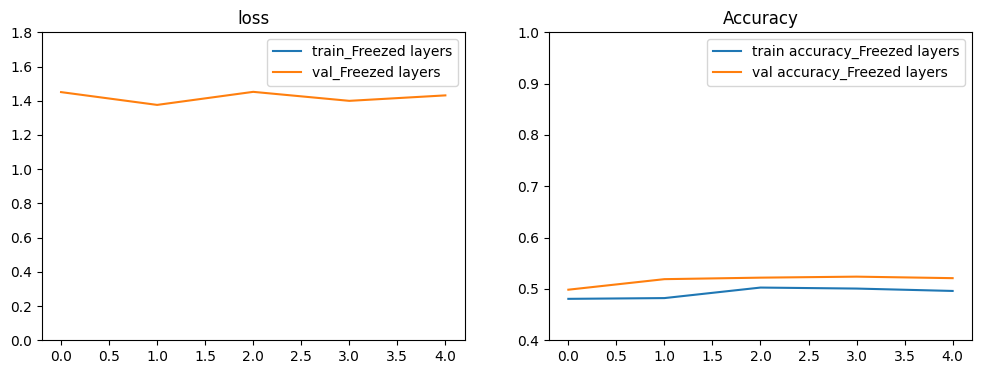

In [15]:
ax1, ax2 = plot_history(history, exp_name= 'Freezed layers');

We're going to gradually unfreeze some layers

In [16]:
for layer in base_model.layers[-3:]:  # Adjust the number of layers to unfreeze
    layer.trainable = True

model.compile(
    optimizer= optimizers.Adam(learning_rate=0.00005),
    loss=losses.SparseCategoricalCrossentropy(from_logits=False),
    metrics=['accuracy']
)

In [17]:
history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs = 1000,
    callbacks = [es],
    verbose = 1
)

Epoch 1/1000
128/128 ━━━━━━━━━━━━━━━━━━━━ 152s 1s/step - accuracy: 0.4148 - loss: 2.5626 - val_accuracy: 0.5024 - val_loss: 1.4753
Epoch 2/1000
128/128 ━━━━━━━━━━━━━━━━━━━━ 145s 1s/step - accuracy: 0.4873 - loss: 1.3103 - val_accuracy: 0.5357 - val_loss: 1.1703
Epoch 3/1000
128/128 ━━━━━━━━━━━━━━━━━━━━ 146s 1s/step - accuracy: 0.5394 - loss: 1.1356 - val_accuracy: 0.5816 - val_loss: 1.0838
Epoch 4/1000
128/128 ━━━━━━━━━━━━━━━━━━━━ 144s 1s/step - accuracy: 0.5717 - loss: 1.0579 - val_accuracy: 0.5943 - val_loss: 1.0472
Epoch 5/1000
128/128 ━━━━━━━━━━━━━━━━━━━━ 145s 1s/step - accuracy: 0.5942 - loss: 1.0237 - val_accuracy: 0.5924 - val_loss: 1.0167
Epoch 6/1000
128/128 ━━━━━━━━━━━━━━━━━━━━ 144s 1s/step - accuracy: 0.5985 - loss: 0.9907 - val_accuracy: 0.6002 - val_loss: 1.0036
Epoch 7/1000
128/128 ━━━━━━━━━━━━━━━━━━━━ 144s 1s/step - accuracy: 0.6139 - loss: 0.9524 - val_accuracy: 0.6022 - val_loss: 0.9833
Epoch 8/1000
128/128 ━━━━━━━━━━━━━━━━━━━━ 145s 1s/step - accuracy: 0.6219 - loss: 0

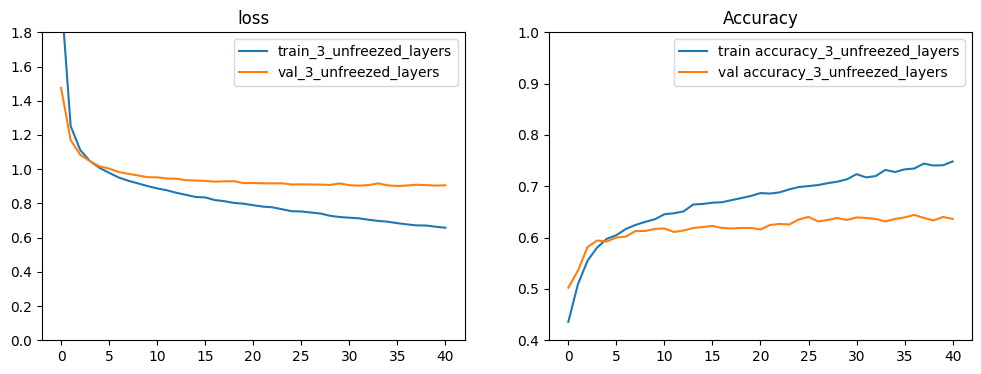

In [18]:
ax1, ax2 = plot_history(history, exp_name= '3_unfreezed_layers');

Unfreeze more layers and see what happens.

# Predicting results

In [23]:
!pip install pyyaml h5py

In [25]:
!mkdir -p saved_model
#model.save('saved_model/my_model')

In [26]:
!ls

data_test			george-first-cnn.ipynb		raw_data
data_train			george-first-exploratory.ipynb	saved_model
george-dataset-directory.ipynb	george_first_model.ipynb	test
george-first-cnn-2.ipynb	george-first-resnet50.ipynb	Untitled.ipynb


In [28]:
model.export('saved_model/my_model')

INFO:tensorflow:Assets written to: saved_model/my_model/assets


INFO:tensorflow:Assets written to: saved_model/my_model/assets


Saved artifact at 'saved_model/my_model'. The following endpoints are available:

* Endpoint 'serve'
  args_0 (POSITIONAL_ONLY): TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name='keras_tensor')
Output Type:
  TensorSpec(shape=(None, 7), dtype=tf.float32, name=None)
Captures:
  139913832796176: TensorSpec(shape=(), dtype=tf.resource, name=None)
  139910658842064: TensorSpec(shape=(), dtype=tf.resource, name=None)
  139910658846112: TensorSpec(shape=(), dtype=tf.resource, name=None)
  139910658848224: TensorSpec(shape=(), dtype=tf.resource, name=None)
  139910658844880: TensorSpec(shape=(), dtype=tf.resource, name=None)
  139910658846640: TensorSpec(shape=(), dtype=tf.resource, name=None)
  139910653227280: TensorSpec(shape=(), dtype=tf.resource, name=None)
  139910653219536: TensorSpec(shape=(), dtype=tf.resource, name=None)
  139910653226752: TensorSpec(shape=(), dtype=tf.resource, name=None)
  139910653229392: TensorSpec(shape=(), dtype=tf.resource, name=None)
  1399106532

In [19]:
from sklearn.metrics import classification_report

In [20]:
import numpy as np
y_true = np.concatenate([y.numpy() for _, y in test_ds], axis=0)
y_pred = model.predict(normalized_test_ds)
y_pred_class = np.argmax(y_pred, axis=1)


2025-03-18 11:36:18.927311: I tensorflow/core/framework/local_rendezvous.cc:407] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


18/18 ━━━━━━━━━━━━━━━━━━━━ 21s 949ms/step


In [21]:
#y_true_class = np.argmax(y_true, axis=1)
classification_report(y_true, y_pred_class)

/home/george/.pyenv/versions/3.10.6/envs/eyesense/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/george/.pyenv/versions/3.10.6/envs/eyesense/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/george/.pyenv/versions/3.10.6/envs/eyesense/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _wa

'              precision    recall  f1-score   support\n\n           0       0.00      0.00      0.00        29\n           1       0.00      0.00      0.00        26\n           2       0.00      0.00      0.00       160\n           3       0.00      0.00      0.00        28\n           4       0.00      0.00      0.00        12\n           5       0.05      0.78      0.10        23\n           6       0.51      0.36      0.42       287\n\n    accuracy                           0.21       565\n   macro avg       0.08      0.16      0.07       565\nweighted avg       0.26      0.21      0.22       565\n'

In [22]:
y_pred_class

array([5, 6, 5, 6, 5, 5, 5, 5, 5, 5, 5, 0, 5, 5, 5, 6, 6, 4, 5, 5, 5, 6,
       5, 5, 5, 5, 5, 5, 6, 6, 5, 5, 6, 5, 5, 6, 6, 5, 6, 5, 5, 5, 5, 3,
       5, 5, 5, 6, 5, 5, 5, 5, 5, 6, 5, 5, 6, 5, 6, 5, 5, 5, 5, 5, 5, 5,
       6, 6, 5, 5, 6, 6, 5, 5, 5, 5, 5, 5, 5, 6, 5, 5, 5, 6, 6, 5, 5, 5,
       6, 6, 6, 5, 6, 6, 6, 6, 6, 5, 6, 6, 6, 6, 6, 5, 5, 5, 6, 5, 5, 5,
       6, 5, 0, 5, 5, 5, 6, 5, 5, 5, 6, 6, 5, 5, 6, 5, 5, 5, 5, 5, 6, 5,
       5, 5, 6, 5, 6, 5, 6, 5, 5, 6, 5, 5, 6, 5, 5, 5, 5, 5, 5, 5, 5, 6,
       6, 6, 5, 5, 5, 5, 5, 6, 5, 6, 6, 6, 5, 6, 6, 5, 0, 5, 6, 5, 5, 5,
       5, 5, 5, 5, 6, 6, 6, 5, 5, 6, 5, 5, 5, 6, 6, 5, 5, 5, 6, 5, 5, 6,
       5, 5, 5, 6, 5, 5, 5, 5, 5, 5, 6, 6, 5, 5, 6, 6, 6, 5, 6, 6, 5, 6,
       5, 6, 5, 5, 6, 6, 6, 5, 6, 5, 5, 5, 5, 6, 6, 5, 5, 5, 6, 6, 5, 5,
       5, 4, 6, 0, 5, 6, 6, 0, 5, 5, 5, 5, 6, 5, 6, 5, 5, 5, 5, 5, 5, 5,
       5, 5, 5, 6, 5, 5, 5, 5, 5, 5, 6, 5, 5, 5, 3, 6, 5, 5, 6, 5, 5, 5,
       6, 5, 5, 5, 6, 5, 6, 5, 5, 5, 5, 5, 5, 5, 5,